Downloading the necessary modules and libraries for the project.

In [1]:
# Using these lines in terminal and remember to set the environment variable to this ipynb file
# conda create --name comp.sgn.120 python=3.11.3
# conda activate comp.sgn.120
# conda install numpy=1.26.2
# pip install ipykernel --upgrade
# conda install -c conda-forge ffmpeg

# Uncomment these lines to install the required packages if you haven't already
# !pip install pydub==0.25.1
# !pip install tqdm==4.66.1
# !pip install librosa==0.10.1
# !pip install matplotlib==3.7.2
# !pip install scikit-learn==1.3.2
# !pip install scipy==1.11.4 
# !pip install pandas==2.1.4


Necessary Modules and Libraries

In [2]:
import os

# Database loading and Feature extraction
from pydub import AudioSegment
import librosa as lb
import librosa.display
from scipy.stats import skew
from scipy.signal import hamming, hann


# Representation
import IPython.display as ipd
import matplotlib.pyplot as plt

# Data processing
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Training
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score




Function for reading the data

In [3]:
def readFolder(folder):
    folder_names = []
    for root, dirs, files in os.walk(folder):
        for name in dirs:
            folder_names.append(os.path.join(root, name))
    return folder_names


def readFileInFolder(folder):
    file_lists = []
    for root, dirs, files in os.walk(folder):
        for name in files:
            file_lists.append(os.path.join(root, name))
    return file_lists

Function for extracting the features

In [4]:
def getMFCC(name, path):
    n_mel=40
    hop_size=128
    n_fft=512
    data, _ = librosa.core.load(name, sr = None)
    try:
        ft1 = lb.feature.mfcc(y= data, n_mfcc=n_mel, hop_length=hop_size, norm="ortho", n_fft=n_fft)
        ft2 = librosa.feature.zero_crossing_rate(y = data)[0]
        ft3 = librosa.feature.spectral_rolloff(y= data)[0]
        ft4 = librosa.feature.spectral_centroid(y = data)[0]
        ft5 = librosa.feature.spectral_contrast(y = data)[0]
        ft6 = librosa.feature.spectral_bandwidth(y = data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

def extractOtherFeatures(y, sr, path=None):
    features = []
    n_mel=40
    hop_size=128
    n_fft=512
    
    # Energy 
    energy = np.sum(np.power(y, 2))
    # RMS
    rms = np.sqrt(np.sum(np.power(y, 2)))
    # Spectrograms
    spec = np.abs(lb.stft(y, n_fft=n_fft, hop_length=hop_size))
    # Mel Spectrogram
    mel = lb.feature.melspectrogram(S=spec, n_mels=n_mel)
    # Log Mel Spectrogram
    logmel = lb.power_to_db(mel)
    # CQT Spectrogram
    cqt = np.abs(lb.cqt(y, sr=sr, hop_length=hop_size, n_bins=40, bins_per_octave=12))   

    features.append(energy)
    features.append(rms)
    features.append(spec)
    features.append(mel)
    features.append(logmel)
    features.append(cqt)    
    
    return features

Evaluating function

In [5]:
def printAccuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average = 'macro')
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return accuracy, precision, recall

Data preprocessing

In [6]:
# Tram_Train: https://freesound.org/people/publictransport/packs/36726/
# Tram_Train: https://freesound.org/people/ali.abdelsalam/packs/36722/
# Bus_Train: https://freesound.org/people/emmakyllikki/packs/36810/
# Bus_Train: https://freesound.org/people/glingden/packs/36807/
# Tram_Test: My own recording
# Bus_Test: My own recording
folder_list = readFolder("audio")
folder_to_read = ["Bus_Test", "Bus_Train", "Tram_Test", "Tram_Train"]
bus_test = []
bus_train = []
tram_test = []
tram_train = []
label = {}
for folder in folder_list:
    # Read all the files and append to the list of files
    files = readFileInFolder(folder)
    for name in folder_to_read:
        if name in folder:
            # Append the files to the corresponding list
            if name == "Bus_Test":
                bus_test = files
                for file in files:
                    label[file] = "bus"
            elif name == "Bus_Train":
                bus_train = files
                for file in files:
                    label[file] = "bus"
            elif name == "Tram_Test":
                tram_test = files
                for file in files:
                    label[file] = "tram"
            elif name == "Tram_Train":
                tram_train = files
                for file in files:
                    label[file] = "tram"

In [7]:
# Prepare Data
train_data = pd.DataFrame()
train_data["fname"] = bus_train + tram_train
test_data = pd.DataFrame()
test_data["fname"] = bus_test + tram_test

train_data = train_data["fname"].progress_apply(getMFCC, path = None)
print("done loading train mfcc")
test_data = test_data["fname"].progress_apply(getMFCC, path = None)
print("done loading test mfcc")


100%|██████████| 98/98 [00:30<00:00,  3.25it/s]


done loading train mfcc


  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\nguye\AppData\Local\Temp\ipykernel_7916\1388096675.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data, _ = librosa.core.load(name, sr = None)
c:\Users\nguye\.conda\envs\comp.sgn.120\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 18/18 [00:08<00:00,  2.01it/s]

done loading test mfcc


In [8]:
train_data["fname"] = bus_train + tram_train
train_data["label"] = train_data["fname"].apply(lambda x: label[x])

print("Train data:")
# print(train_data)


Train data:


In [9]:
test_data["fname"] = bus_test + tram_test
test_data["label"] = test_data["fname"].apply(lambda x: label[x])

print("Test data:")
# print(test_data)

Test data:


In [10]:
# Functions from Random Foresth using MFCC ttps://www.kaggle.com/amlanpraharaj/random-forest-using-mfcc-features
def getDataset(train_data, test_data):
    X = train_data.drop(['label', 'fname'], axis=1)
    feature_names = list(X.columns)
    X = X.values

    labels = np.sort(np.unique(train_data.label.values))

    num_class = len(labels)
    c2i = {}
    i2c = {}
    for i, c in enumerate(labels):
        c2i[c] = i
        i2c[i] = c
    y = np.array([c2i[x] for x in train_data.label.values])
    X_test = test_data.drop(['label', 'fname'], axis=1).values
    y_test = np.array([c2i[x] for x in test_data.label.values])
    return(X, y, X_test, y_test, feature_names, num_class, c2i, i2c)


In [11]:
X, y, X_test, y_test, feature_names, num_class, c2i, i2c = getDataset(train_data, test_data)

In [12]:
# A function that exporting the csv file from the beginning of the
def exportCSV(y_pred, y_test, filename, bus_test = bus_test, tram_test = tram_test, i2c = i2c):
    # convert the binary data into a class label (bus or tram)
    y_pred_label = []
    for i in range(len(y_pred)):
        y_pred_label.append(i2c[y_pred[i]])
    y_pred_label = np.array(y_pred_label)
    # print(y_pred_label)

    # convert the binary data into a class label (bus or tram)
    y_test_label = []
    for i in range(len(y_test)):
        y_test_label.append(i2c[y_test[i]])
    y_test_label = np.array(y_test_label)
    # print(y_test_label)
    y_test_name = []
    for i in range(len(bus_test)):
        y_test_name.append(os.path.basename(bus_test[i]))
    for i in range(len(tram_test)):
        y_test_name.append(os.path.basename(tram_test[i]))
    y_test_name = np.array(y_test_name)
    # print(y_test_name)

    # Export the CSV file using y_test_name, y_pred_label, and y_test_label
    df = pd.DataFrame({'fname': y_test_name, 'y_pred': y_pred_label, 'y_test': y_test_label})
    df.to_csv(filename, index=False)

In [13]:
def dataPreprocessing(X, X_test):
    # Found array with 0 feature(s) (shape=(98, 0)) while a minimum of 1 is required by StandardScaler.
    if X.shape[1] == 0:
        X = np.zeros((X.shape[0], 1))
        X_scaled = X
        X_pca = X
    if X_test.shape[1] == 0:
        X_test = np.zeros((X_test.shape[0], 1))
        X_test_scaled = X_test
        X_test_pca = X_test
        return X_scaled, X_test_scaled, X_pca, X_test_pca
    
    # Apply scaling for PCA
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA for dimension reduction
    pca = PCA(n_components=65).fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(sum(pca.explained_variance_ratio_))
    return X_scaled, X_test_scaled, X_pca, X_test_pca

In [14]:
def dataProcessAndTrainAndEvaluate(X_pca, y, feature = "MFCC"):
    # Build a KNN model
    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.01, random_state = 42, shuffle = True)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Test the kNN model with the test data
    y_pred = knn.predict(X_test_pca)
    print("KNN: ")
    printAccuracy(y_test, y_pred)
    exportCSV(y_pred, y_test, f'{feature}_KNN_output.csv')
    
    # Build a SVM model
    X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.01, random_state = 42, shuffle = True)
    clf = SVC(kernel = 'rbf', probability=True)
    clf.fit(X_train, y_train)
    
    # Test the SVM model with the test data
    y_pred = clf.predict(X_test_pca)
    print("SVM: ")
    printAccuracy(y_test, y_pred)
    exportCSV(y_pred, y_test, f'{feature}_SVM_output.csv')

In [15]:
X_scaled, X_test_scaled, X_pca, X_test_pca = dataPreprocessing(X, X_test)
dataProcessAndTrainAndEvaluate(X_pca, y)

0.9828026391973513
KNN: 
Accuracy:  0.7222222222222222
Precision:  0.8333333333333333
Recall:  0.6875
SVM: 
Accuracy:  0.7222222222222222
Precision:  0.7207792207792207
Recall:  0.7125


In [16]:
# Read the audio files
bus_test_audio = []
bus_train_audio = []
tram_test_audio = []
tram_train_audio = []
for file in bus_train:
    y, sr = lb.load(file, sr=None)
    bus_train_audio.append((y, sr))
for file in tram_train:
    y, sr = lb.load(file, sr=None)
    tram_train_audio.append((y, sr))

# Read the audio files in m4a format
for file in bus_test:
    sound = AudioSegment.from_file(file, format="m4a")
    sound.export("temp.wav", format="wav")
    y, sr = lb.load("temp.wav", sr=None)
    bus_test_audio.append((y, sr))
    os.remove("temp.wav")
for file in tram_test:
    sound = AudioSegment.from_file(file, format="m4a")
    sound.export("temp.wav", format="wav")
    y, sr = lb.load("temp.wav", sr=None)
    tram_test_audio.append((y, sr))
    os.remove("temp.wav")

In [17]:
print("Number of bus train audio files: ", len(bus_train_audio))
print("Number of tram train audio files: ", len(tram_train_audio))
print("Number of bus test audio files: ", len(bus_test_audio))
print("Number of tram test audio files: ", len(tram_test_audio))

Number of bus train audio files:  39
Number of tram train audio files:  59
Number of bus test audio files:  10
Number of tram test audio files:  8


In [18]:
tram_features = []
bus_features = []

tram_test_features = []
bus_test_features = []
# using the data from tram_train_audio and bus_train_audio
for y, sr in tram_train_audio:
    features = extractOtherFeatures(y, sr)
    tram_features.append(features)

for y, sr in bus_train_audio:
    features = extractOtherFeatures(y, sr)
    bus_features.append(features)

# using the data from tram_test_audio and bus_test_audio
for y, sr in tram_test_audio:
    features = extractOtherFeatures(y, sr)
    tram_test_features.append(features)
    
for y, sr in bus_test_audio:
    features = extractOtherFeatures(y, sr)
    bus_test_features.append(features)

In [19]:
# Continuing with other features
train_data_list = []
test_data_list = []
features = tram_features + bus_features
features_test = tram_test_features + bus_test_features
feature_names_list = ["energy", "rms", "spec", "mel", "logmel", "cqt"]
for i in range(len(bus_features[0])): # 6
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    train_data["fname"] = bus_train + tram_train
    test_data["fname"] = bus_test + tram_test
    # for j in range(len(features)): # 98
    train_data["label"] = train_data["fname"].apply(lambda x: label[x])
    test_data["label"] = test_data["fname"].apply(lambda x: label[x])

    # train_data[feature_names[i]] = [x[i] for x in features]
    # test_data[feature_names[i]] = [x[i] for x in features_test]
    train_data["fname"] = [x[i] for x in features]
    test_data["fname"] = [x[i] for x in features_test]
    
    train_data_list.append(train_data)
    test_data_list.append(test_data)      

# # concatenate the features_names into 1 dataframe, with keeping the fname and label columns and not concatenating them
# train_data = pd.concat(train_data_list, axis=1)
# test_data = pd.concat(test_data_list, axis=1)

# # fix the overlapping columns
# train_data = train_data.loc[:,~train_data.columns.duplicated()]
# test_data = test_data.loc[:,~test_data.columns.duplicated()]

In [20]:
for i in range(len(train_data_list)):
    print("Feature: ", feature_names_list[i])
    X, y, X_test, y_test, feature_names, num_class, c2i, i2c = getDataset(train_data_list[i], test_data_list[i])
    X_scaled, X_test_scaled, X_pca, X_test_pca = dataPreprocessing(X, X_test)
    # print(feature_names_list[i])
    dataProcessAndTrainAndEvaluate(X_pca, y, feature_names_list[i])
    print()

Feature:  energy
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5

Feature:  rms
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5

Feature:  spec
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5

Feature:  mel
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5

Feature:  logmel
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5

Feature:  cqt
KNN: 
Accuracy:  0.4444444444444444
Precision:  0.7222222222222222
Recall:  0.5
SVM: 
Accuracy:  0.44444

In [21]:
# Combine the content of the csv files into 1 csv file, keep the fname and real lavel, and combine the predicted label into different columns with the feature name as the column name
# energy_KNN_output.csv, logmel_KNN_output.csv, mel_KNN_output.csv, rms_KNN_output.csv, spec_KNN_output.csv, MFCC_KNN_output.csv, cqt_KNN_output.csv
with open('energy_KNN_output.csv') as f:
    energy_KNN = pd.read_csv(f)
os.remove('energy_KNN_output.csv')
with open('logmel_KNN_output.csv') as f:
    logmel_KNN = pd.read_csv(f)
os.remove('logmel_KNN_output.csv')
with open('mel_KNN_output.csv') as f:
    mel_KNN = pd.read_csv(f)
os.remove('mel_KNN_output.csv')
with open('rms_KNN_output.csv') as f:
    rms_KNN = pd.read_csv(f)
os.remove('rms_KNN_output.csv')
with open('spec_KNN_output.csv') as f:
    spec_KNN = pd.read_csv(f)
os.remove('spec_KNN_output.csv')
with open('MFCC_KNN_output.csv') as f:
    MFCC_KNN = pd.read_csv(f)
os.remove('MFCC_KNN_output.csv')
with open('cqt_KNN_output.csv') as f:
    cqt_KNN = pd.read_csv(f)
os.remove('cqt_KNN_output.csv')

energy_KNN.rename(columns={'y_pred': 'energy'}, inplace=True)
logmel_KNN.rename(columns={'y_pred': 'logmel'}, inplace=True)
mel_KNN.rename(columns={'y_pred': 'mel'}, inplace=True)
rms_KNN.rename(columns={'y_pred': 'rms'}, inplace=True)
spec_KNN.rename(columns={'y_pred': 'spec'}, inplace=True)
MFCC_KNN.rename(columns={'y_pred': 'MFCC'}, inplace=True)
cqt_KNN.rename(columns={'y_pred': 'cqt'}, inplace=True)

# Concatenate the dataframes, deleting the duplicate columns
KNN_concat = pd.concat([energy_KNN, logmel_KNN, mel_KNN, rms_KNN, spec_KNN, MFCC_KNN, cqt_KNN], axis=1)
KNN_concat = KNN_concat.loc[:,~KNN_concat.columns.duplicated()]
print(KNN_concat)

# energy_SVM_output.csv, logmel_SVM_output.csv, mel_SVM_output.csv, rms_SVM_output.csv, spec_SVM_output.csv, MFCC_SVM_output.csv, cqt_SVM_output.csv
with open('energy_SVM_output.csv') as f:
    energy_SVM = pd.read_csv(f)
os.remove('energy_SVM_output.csv')

with open('logmel_SVM_output.csv') as f:
    logmel_SVM = pd.read_csv(f)
os.remove('logmel_SVM_output.csv')

with open('mel_SVM_output.csv') as f:
    mel_SVM = pd.read_csv(f)
os.remove('mel_SVM_output.csv')

with open('rms_SVM_output.csv') as f:
    rms_SVM = pd.read_csv(f)
os.remove('rms_SVM_output.csv')

with open('spec_SVM_output.csv') as f:
    spec_SVM = pd.read_csv(f)
os.remove('spec_SVM_output.csv')

with open('MFCC_SVM_output.csv') as f:
    MFCC_SVM = pd.read_csv(f)
os.remove('MFCC_SVM_output.csv')

with open('cqt_SVM_output.csv') as f:
    cqt_SVM = pd.read_csv(f)
os.remove('cqt_SVM_output.csv')

energy_SVM.rename(columns={'y_pred': 'energy'}, inplace=True)
logmel_SVM.rename(columns={'y_pred': 'logmel'}, inplace=True)
mel_SVM.rename(columns={'y_pred': 'mel'}, inplace=True)
rms_SVM.rename(columns={'y_pred': 'rms'}, inplace=True)
spec_SVM.rename(columns={'y_pred': 'spec'}, inplace=True)
MFCC_SVM.rename(columns={'y_pred': 'MFCC'}, inplace=True)
cqt_SVM.rename(columns={'y_pred': 'cqt'}, inplace=True)

# Concatenate the dataframes, deleting the duplicate columns
SVM_concat = pd.concat([energy_SVM, logmel_SVM, mel_SVM, rms_SVM, spec_SVM, MFCC_SVM, cqt_SVM], axis=1)
SVM_concat = SVM_concat.loc[:,~SVM_concat.columns.duplicated()]
print(SVM_concat)

         fname energy y_test logmel   mel   rms  spec  MFCC   cqt
0    Bus_1.m4a   tram    bus   tram  tram  tram  tram   bus  tram
1   Bus_10.m4a   tram    bus   tram  tram  tram  tram   bus  tram
2    Bus_2.m4a   tram    bus   tram  tram  tram  tram   bus  tram
3    Bus_3.m4a   tram    bus   tram  tram  tram  tram   bus  tram
4    Bus_4.m4a   tram    bus   tram  tram  tram  tram   bus  tram
5    Bus_5.m4a   tram    bus   tram  tram  tram  tram   bus  tram
6    Bus_6.m4a   tram    bus   tram  tram  tram  tram   bus  tram
7    Bus_7.m4a   tram    bus   tram  tram  tram  tram   bus  tram
8    Bus_8.m4a   tram    bus   tram  tram  tram  tram   bus  tram
9    Bus_9.m4a   tram    bus   tram  tram  tram  tram   bus  tram
10  Tram_1.m4a   tram   tram   tram  tram  tram  tram  tram  tram
11  Tram_2.m4a   tram   tram   tram  tram  tram  tram   bus  tram
12  Tram_3.m4a   tram   tram   tram  tram  tram  tram   bus  tram
13  Tram_4.m4a   tram   tram   tram  tram  tram  tram   bus  tram
14  Tram_5

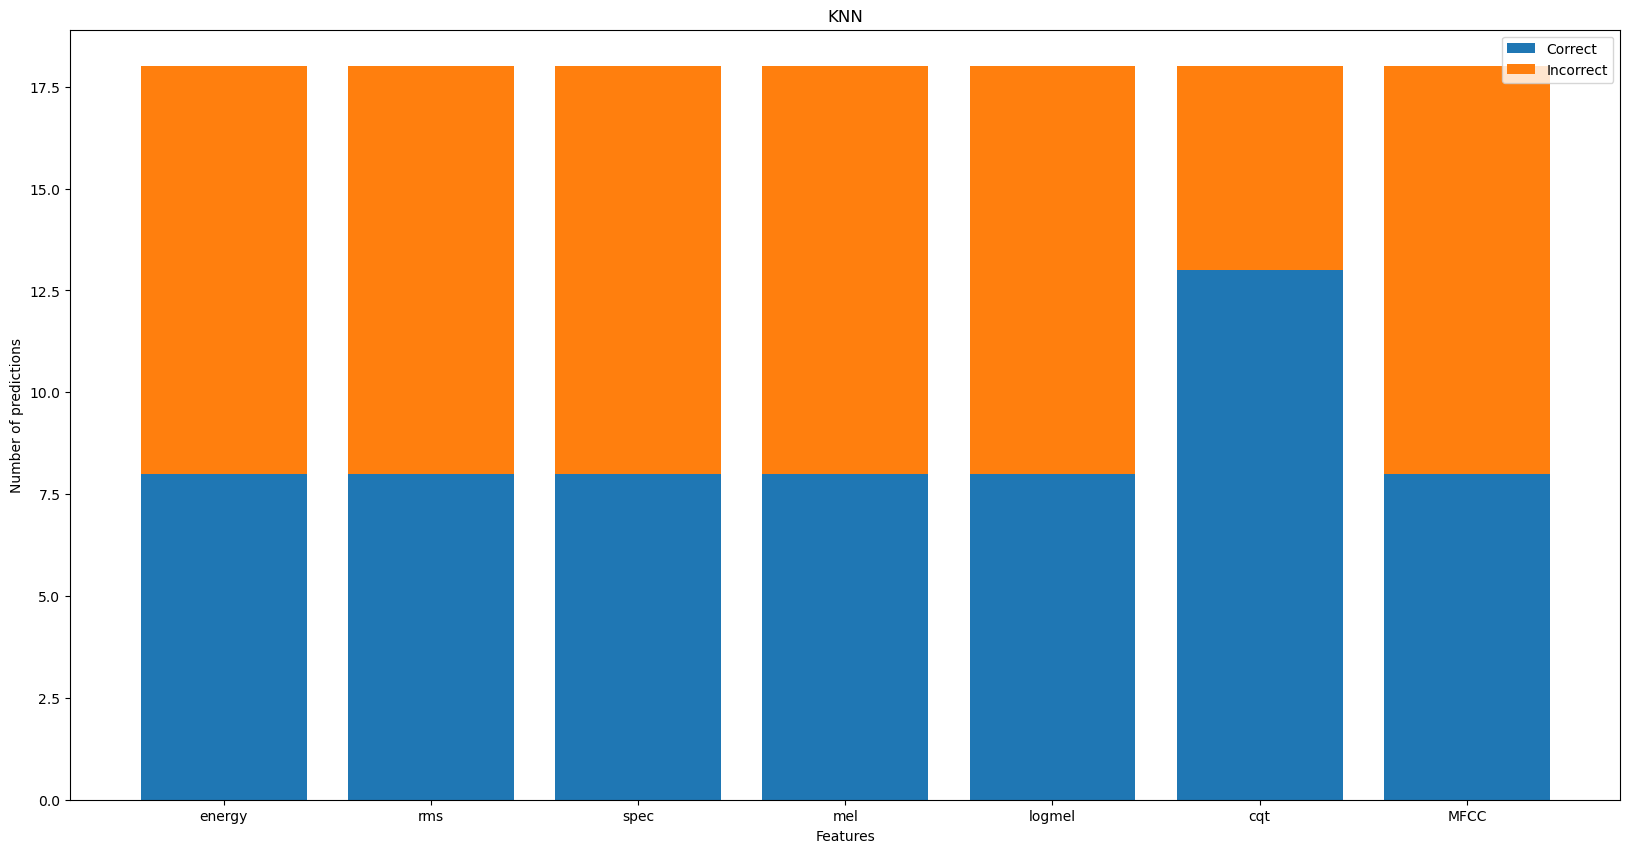

In [22]:
# Print the histogram, counting the number of correct predictions and incorrect predictions for each feature by comparing the predicted label which has been changed by the name and the real label
# KNN
# Calculate the number of correct predictions and incorrect predictions for each feature
energy_KNN_correct = 0
energy_KNN_incorrect = 0
logmel_KNN_correct = 0
logmel_KNN_incorrect = 0
mel_KNN_correct = 0
mel_KNN_incorrect = 0
rms_KNN_correct = 0
rms_KNN_incorrect = 0
spec_KNN_correct = 0
spec_KNN_incorrect = 0
MFCC_KNN_correct = 0
MFCC_KNN_incorrect = 0
cqt_KNN_correct = 0
cqt_KNN_incorrect = 0

for i in range(len(KNN_concat)):
    if KNN_concat['energy'][i] == KNN_concat['y_test'][i]:
        energy_KNN_correct += 1
    else:
        energy_KNN_incorrect += 1
    if KNN_concat['logmel'][i] == KNN_concat['y_test'][i]:
        logmel_KNN_correct += 1
    else:
        logmel_KNN_incorrect += 1
    if KNN_concat['mel'][i] == KNN_concat['y_test'][i]:
        mel_KNN_correct += 1
    else:
        mel_KNN_incorrect += 1
    if KNN_concat['rms'][i] == KNN_concat['y_test'][i]:
        rms_KNN_correct += 1
    else:
        rms_KNN_incorrect += 1
    if KNN_concat['spec'][i] == KNN_concat['y_test'][i]:
        spec_KNN_correct += 1
    else:
        spec_KNN_incorrect += 1
    if KNN_concat['MFCC'][i] == KNN_concat['y_test'][i]:
        MFCC_KNN_correct += 1
    else:
        MFCC_KNN_incorrect += 1
    if KNN_concat['cqt'][i] == KNN_concat['y_test'][i]:
        cqt_KNN_correct += 1
    else:
        cqt_KNN_incorrect += 1
# add to feature_names_list MFCC before cqt
feature_names_list = ["energy", "logmel", "mel", "rms", "spec", "MFCC", "cqt"]
# Plot the histogram
plt.figure(figsize=(20,10))
plt.bar(feature_names_list, [energy_KNN_correct, logmel_KNN_correct, mel_KNN_correct, rms_KNN_correct, spec_KNN_correct, MFCC_KNN_correct, cqt_KNN_correct], label="Correct")
plt.bar(feature_names_list, [energy_KNN_incorrect, logmel_KNN_incorrect, mel_KNN_incorrect, rms_KNN_incorrect, spec_KNN_incorrect, MFCC_KNN_incorrect, cqt_KNN_incorrect], bottom=[energy_KNN_correct, logmel_KNN_correct, mel_KNN_correct, rms_KNN_correct, spec_KNN_correct, MFCC_KNN_correct, cqt_KNN_correct], label="Incorrect")

plt.legend()
plt.xlabel("Features")
plt.ylabel("Number of predictions")
plt.title("KNN")
plt.show()

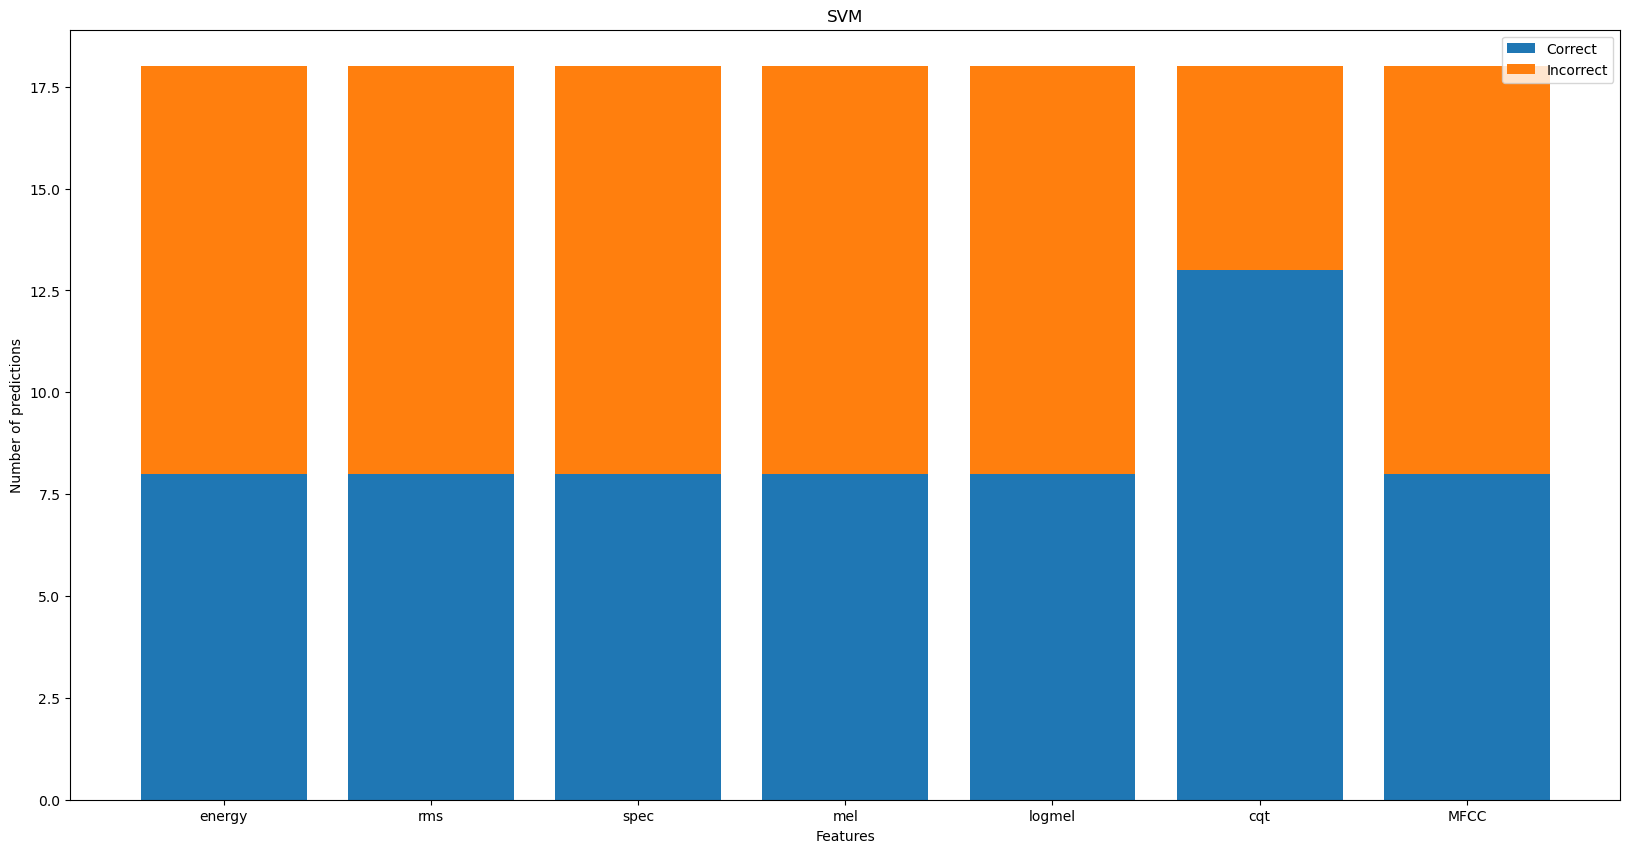

In [23]:
# SVM
# Calculate the number of correct predictions and incorrect predictions for each feature
energy_SVM_correct = 0
energy_SVM_incorrect = 0
logmel_SVM_correct = 0
logmel_SVM_incorrect = 0
mel_SVM_correct = 0
mel_SVM_incorrect = 0
rms_SVM_correct = 0
rms_SVM_incorrect = 0
spec_SVM_correct = 0
spec_SVM_incorrect = 0
MFCC_SVM_correct = 0
MFCC_SVM_incorrect = 0
cqt_SVM_correct = 0
cqt_SVM_incorrect = 0

for i in range(len(SVM_concat)):
    if SVM_concat['energy'][i] == SVM_concat['y_test'][i]:
        energy_SVM_correct += 1
    else:
        energy_SVM_incorrect += 1
    if SVM_concat['logmel'][i] == SVM_concat['y_test'][i]:
        logmel_SVM_correct += 1
    else:
        logmel_SVM_incorrect += 1
    if SVM_concat['mel'][i] == SVM_concat['y_test'][i]:
        mel_SVM_correct += 1
    else:
        mel_SVM_incorrect += 1
    if SVM_concat['rms'][i] == SVM_concat['y_test'][i]:
        rms_SVM_correct += 1
    else:
        rms_SVM_incorrect += 1
    if SVM_concat['spec'][i] == SVM_concat['y_test'][i]:
        spec_SVM_correct += 1
    else:
        spec_SVM_incorrect += 1
    if SVM_concat['MFCC'][i] == SVM_concat['y_test'][i]:
        MFCC_SVM_correct += 1
    else:
        MFCC_SVM_incorrect += 1
    if SVM_concat['cqt'][i] == SVM_concat['y_test'][i]:
        cqt_SVM_correct += 1
    else:
        cqt_SVM_incorrect += 1
    
# Plot the histogram
plt.figure(figsize=(20,10))
plt.bar(feature_names_list, [energy_SVM_correct, logmel_SVM_correct, mel_SVM_correct, rms_SVM_correct, spec_SVM_correct, MFCC_SVM_correct, cqt_SVM_correct], label="Correct")
plt.bar(feature_names_list, [energy_SVM_incorrect, logmel_SVM_incorrect, mel_SVM_incorrect, rms_SVM_incorrect, spec_SVM_incorrect, MFCC_SVM_incorrect, cqt_SVM_incorrect], bottom=[energy_SVM_correct, logmel_SVM_correct, mel_SVM_correct, rms_SVM_correct, spec_SVM_correct, MFCC_SVM_correct, cqt_SVM_correct], label="Incorrect")

plt.legend()
plt.xlabel("Features")
plt.ylabel("Number of predictions")
plt.title("SVM")
plt.show()

In [24]:
# export the csv file
KNN_concat.to_csv("KNN_concat.csv", index=False)
SVM_concat.to_csv("SVM_concat.csv", index=False)